# Water consumption - Models training, evaluation and prediction

## Sections
1. Read and prepare datasets
    - Import libraries
    - Read datasets
    - Prepare dataframes 
2. Linear regression models definition
    - Compute correlations between independant variables
    - Define linear regression models and formula
3. Linear regression models training and prediction with cross-validation
    - Define the cross-validation plan
    - Train models with cross-validation plan
    - Predict consumption values
4. Linear regression models performance evaluation
    - Evaluate the models with cross-validation vs. all data combined (RMSE, R-squared, Standard Deviation)
    - Visualization of cross-validation prediction values and prediction values based on all data frame
5. Random forest models definition
    - Define random forest models and formula (same as linear regression)
6. Random forest models training and predictions with cross-validation
    - Define the cross-validation plan
    - Train models with cross-validation plan
    - Predict consumption values
7. Random forest models performance evaluation
    - Evaluate the models with cross-validation vs. all data combined (RMSE, R-squared, Standard Deviation)
    - Visualization of cross-validation prediction values and prediction values based on all data frame
8. Models comparison: Linear regression vs. random forest

### 1. Read and prepare datasets

##### Import libraries

In [18]:
# Import libraries for plotting, reading and wrangling data
library(tidyverse)
library(scales)
library(here)
library(ggplot2)
library(vtreat)
library(cowplot)
library(ranger)
source(here::here("scripts/Common", "func.R"))

##### Read datasets

In [2]:
# Read water datasets: Hourly, Daily, Monthly
WaterHourDF  <-  read_csv(here::here("curated/water", "gold_hourly_water.csv"),   show_col_types = FALSE)
WaterDayDF   <-  read_csv(here::here("curated/water", "gold_daily_water.csv"),    show_col_types = FALSE)
WaterMonthDF <-  read_csv(here::here("curated/water", "gold_monthly_water.csv"),  show_col_types = FALSE) %>%
                mutate(year_month = factor(paste(year, month, sep = "-")))

# Read weather datasets: Hourly, Daily, Monthly
WeatherHourDF  <-   read_csv(here::here("curated/weather", "gold_hourly_weather.csv"),   show_col_types = FALSE)
WeatherDayDF   <-   read_csv(here::here("curated/weather", "gold_daily_weather.csv"),    show_col_types = FALSE)
WeatherMonthDF <-   read_csv(here::here("curated/weather", "gold_monthly_weather.csv"),  show_col_types = FALSE) %>%
                    mutate(year_month = factor(paste(year, month, sep = "-")))

##### Prepare dataframes

In [3]:
# Join hourly weather and water data
WWHourDF <- WeatherHourDF %>%
    inner_join(WaterHourDF,   by = c("year", "month", "day", "hour"), suffix = c("", "_water")) %>%
    select(year, month, day, hour, avg_temp, avg_dewpt_temp, avg_rel_hum_pct, avg_wind_dir, avg_wind_spd, avg_visib, avg_stn_press, avg_hmdx, avg_wind_chill, consumption)
# Join daily weather and water data
WWDayDF <- WeatherDayDF %>%
    inner_join(WaterDayDF,   by = c("year", "month", "day"), suffix = c("", "_water")) %>%
    select(year, month, day, avg_temp, avg_dewpt_temp, avg_rel_hum_pct, avg_wind_dir, avg_wind_spd, avg_visib, avg_stn_press, avg_hmdx, avg_wind_chill, consumption)
# Join monthly weather and water data
WWMonthDF <- WeatherMonthDF %>%
    inner_join(WaterMonthDF,   by = c("year_month", "year", "month"), suffix = c("", "_water")) %>%
    select(year_month, year, month, avg_temp, avg_dewpt_temp, avg_rel_hum_pct, avg_wind_dir, avg_wind_spd, avg_visib, avg_stn_press, avg_hmdx, avg_wind_chill, consumption)

### 2. Linear regression models definition

##### Compute correlations between independant variables
This will give inputs about interactions that need to be defined in the linear regression models formula

In [4]:
# Define the vector for weather metrics
corrVec <- c("avg_temp", "avg_dewpt_temp", "avg_rel_hum_pct", "avg_visib")
# Create correlation dataframe for hourly data
corrHourDF  <- pairwise_correlations_function(WWHourDF, corrVec, "hour")
# Create correlation dataframe for daily data
corrDayDF   <- pairwise_correlations_function(WWDayDF, corrVec, "day")
# Create correlation dataframe for monthly data
corrMonthDF <- pairwise_correlations_function(WWMonthDF, corrVec, "month")
# Combine all three dataframe together
combinedCorrsDF <- corrHourDF %>%
    union(corrDayDF) %>%
        union(corrMonthDF)

# Display correlation results
head(
    combinedCorrsDF %>%
        pivot_wider(names_from = timeFrame, values_from = correlation)
)

independantVariableOne,independantVariableTwo,hour,day,month
<chr>,<chr>,<dbl>,<dbl>,<dbl>
avg_temp,avg_dewpt_temp,0.888,0.922,0.961
avg_temp,avg_rel_hum_pct,-0.394,-0.324,-0.578
avg_temp,avg_visib,0.391,0.420,0.833
avg_dewpt_temp,avg_rel_hum_pct,0.067,0.067,-0.332
avg_dewpt_temp,avg_visib,0.142,0.174,0.712
avg_rel_hum_pct,avg_visib,-0.587,-0.665,-0.748


##### Define formula and linear regression models

In [5]:
#=========================
# FORMULA
#=========================
# Define model formula
# Only the independant variables that have a correlation higher than 50% for all time frames are considered for interactions
fmla_linear_regression <- as.formula("consumption ~ avg_temp + avg_dewpt_temp + avg_rel_hum_pct + avg_visib + avg_temp:avg_dewpt_temp + avg_rel_hum_pct:avg_visib")

#===========================================
# LINEAR REGRESSION MODELS BASED ON ALL DATA
#===========================================
# Create linear regression models for all three time frames
mdl_linear_regression_hour  <- lm(fmla_linear_regression, data = WWHourDF)
mdl_linear_regression_day   <- lm(fmla_linear_regression, data = WWDayDF)
mdl_linear_regression_month <- lm(fmla_linear_regression, data = WWMonthDF)

# Add column with prediction values based on all data (1 training set = all data frame)
WWHourDF$lr_pred   <- predict(mdl_linear_regression_hour,  WWHourDF)
WWDayDF$lr_pred    <- predict(mdl_linear_regression_day,   WWDayDF)
WWMonthDF$lr_pred  <- predict(mdl_linear_regression_month, WWMonthDF)

### 3. Linear regression models training and predictions with cross-validation

##### Define cross-validation plan and train data

In [6]:
# HOUR
WWHourDF    <- cross_validation_func(WWHourDF,  3, fmla_linear_regression, "linear_regression", "lr_pred_cv")
# DAY
WWDayDF     <- cross_validation_func(WWDayDF,   3, fmla_linear_regression, "linear_regression", "lr_pred_cv")
# MONTH
WWMonthDF   <- cross_validation_func(WWMonthDF, 3, fmla_linear_regression, "linear_regression", "lr_pred_cv")

### 4. Linear regression models performance evaluation

##### Evaluate the models with cross-validation vs. all data combined (RMSE, R-squared, Standard Deviation)

In [7]:
# Models and dataframes to list for 'performance_matrix_func'
lr_models_vec <- list(mdl_linear_regression_hour, mdl_linear_regression_day, mdl_linear_regression_month)
dataframes_vec <- list(WWHourDF, WWDayDF, WWMonthDF)

In [8]:
#=======================================
# MODELS BASED ON ALL DATA
#=======================================
# Create matrix containing all metrics needed for model performance evaluation
ModelsPerformanceMatrixAllData <- performance_matrix_func(lr_models_vec, dataframes_vec, "consumption", "lr_pred")
# Display performance results
head(ModelsPerformanceMatrixAllData)

,timeFrame,rSquared,rmse,sd,rmseIsSmallerThanSd
,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
1,hour,0.003737015,50.07855,50.17381,TRUE
2,day,0.069939118,258.58939,268.31977,TRUE
3,month,0.423568718,4072.99797,5480.01978,TRUE


In [9]:
#=======================================
# MODELS CROSS-VALIDATION
#=======================================
# Create matrix containing all metrics needed for model performance evaluation
ModelsPerformanceMatrixCV <- performance_matrix_func(lr_models_vec, dataframes_vec, "consumption", "lr_pred_cv")
# Display performance results
head(ModelsPerformanceMatrixCV)

,timeFrame,rSquared,rmse,sd,rmseIsSmallerThanSd
,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
1,hour,0.003067456,50.09537,50.17381,TRUE
2,day,0.051867790,261.08953,268.31977,TRUE
3,month,-0.058242492,5518.65215,5480.01978,FALSE


##### Visualization of cross-validation prediction values and prediction values based on all data frame

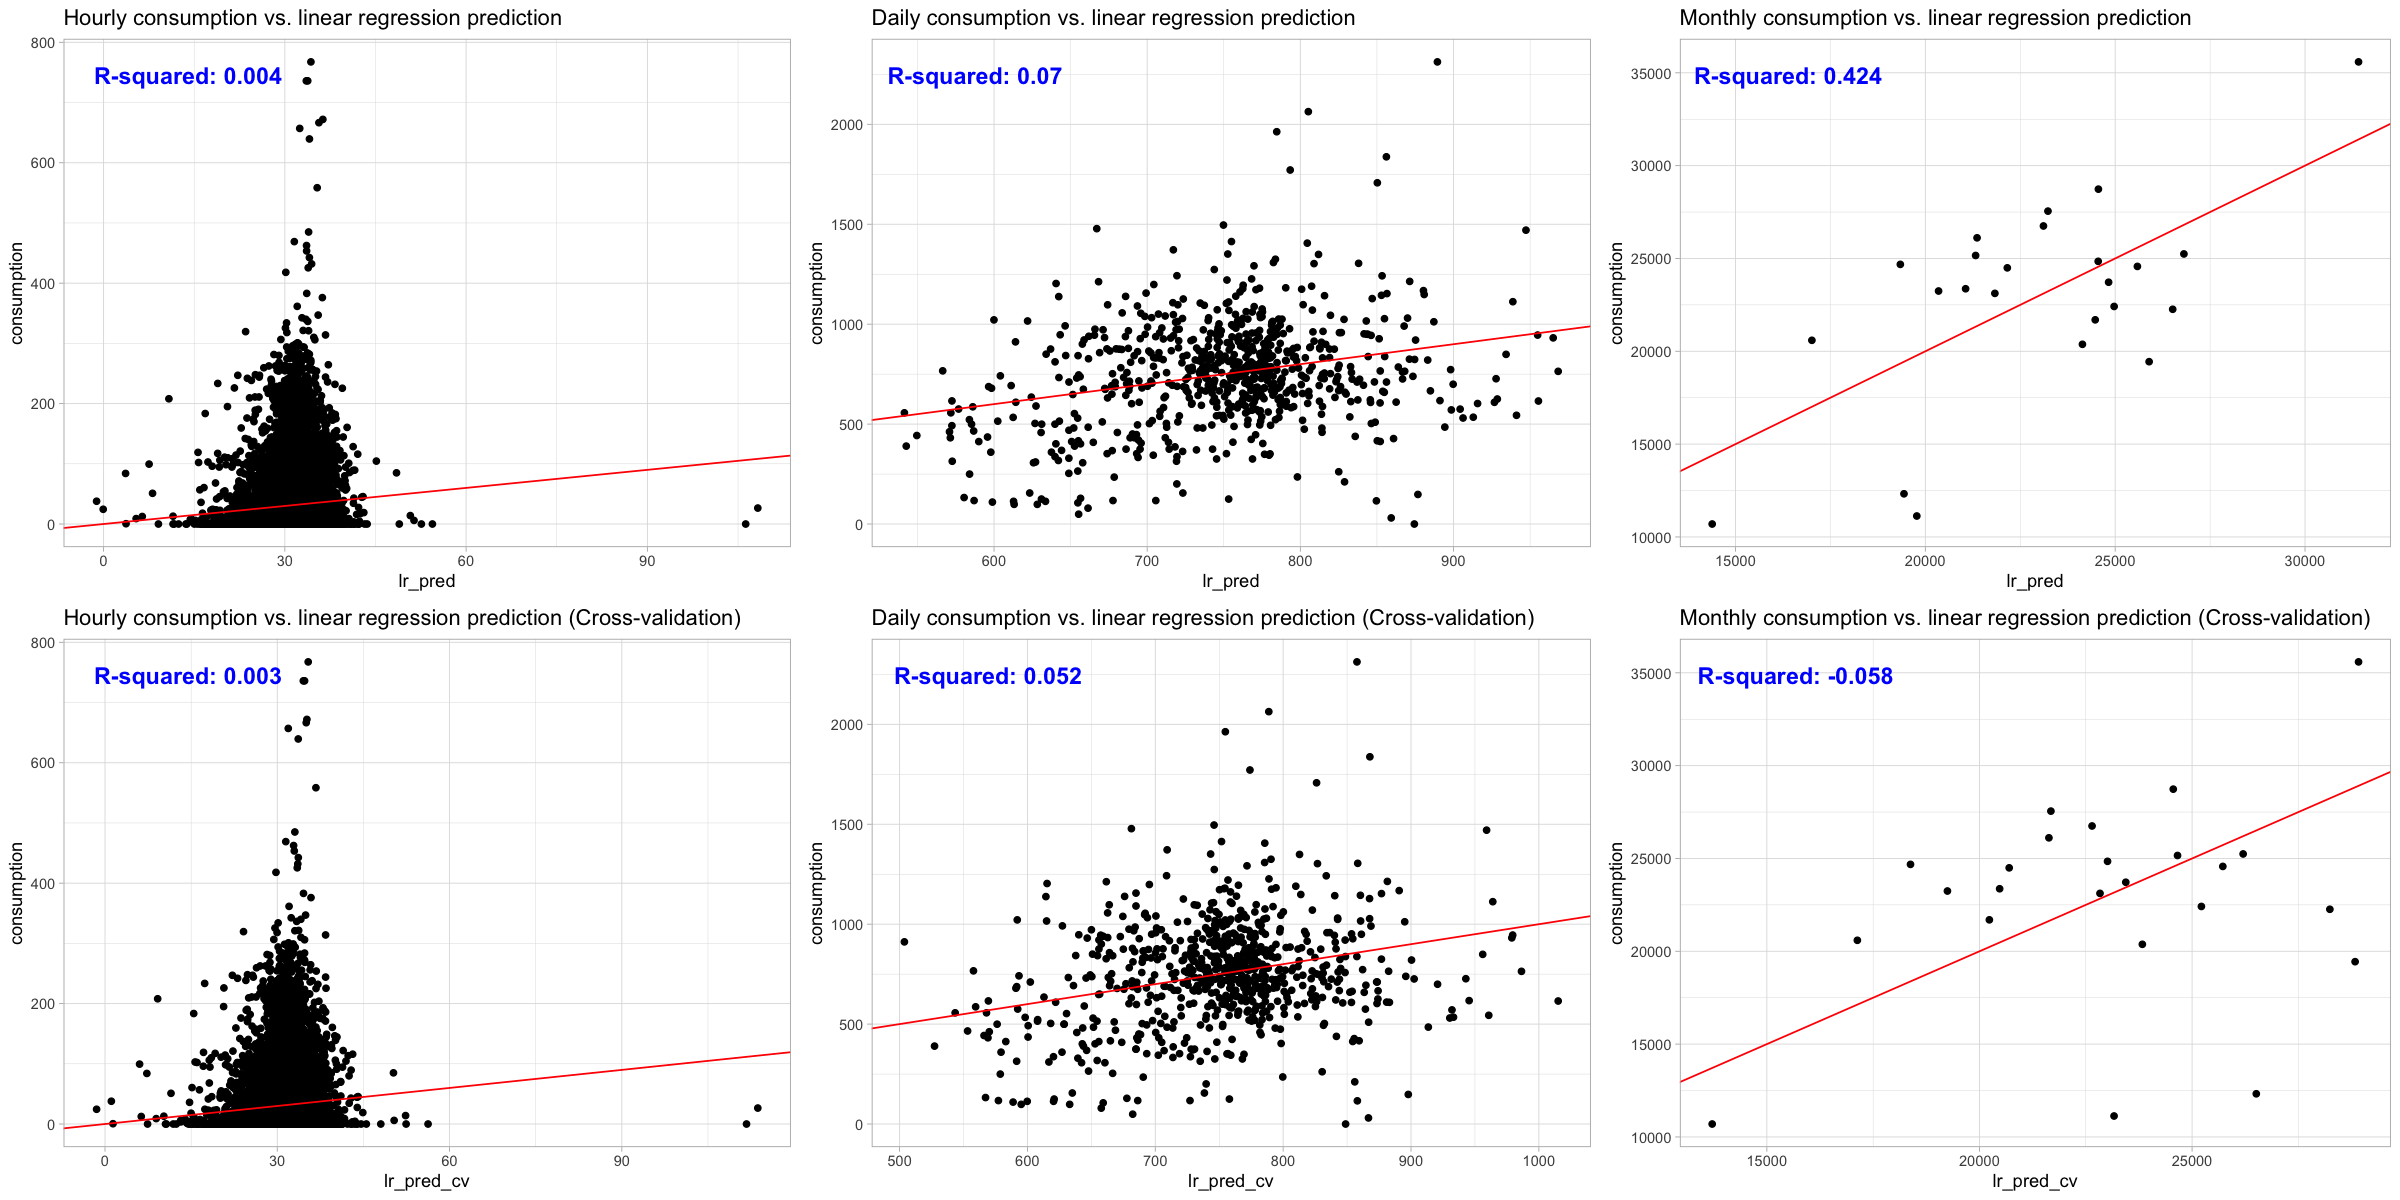

In [10]:
# Set configuration for plot size
options(repr.plot.width = 20, repr.plot.height = 10)

# Plot definitions
plt_hour_lr_pred        <- ggplot(WWHourDF,     aes(x = lr_pred,    y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Hourly consumption vs. linear regression prediction")                      + theme_light()
plt_day_lr_pred         <- ggplot(WWDayDF,      aes(x = lr_pred,    y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Daily consumption vs. linear regression prediction")                       + theme_light()
plt_month_lr_pred       <- ggplot(WWMonthDF,    aes(x = lr_pred,    y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Monthly consumption vs. linear regression prediction")                     + theme_light()
plt_hour_lr_pred_cv     <- ggplot(WWHourDF,     aes(x = lr_pred_cv, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Hourly consumption vs. linear regression prediction (Cross-validation)")   + theme_light()
plt_day_lr_pred_cv      <- ggplot(WWDayDF,      aes(x = lr_pred_cv, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Daily consumption vs. linear regression prediction (Cross-validation)")    + theme_light()
plt_month_lr_pred_cv    <- ggplot(WWMonthDF,    aes(x = lr_pred_cv, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Monthly consumption vs. linear regression prediction (Cross-validation)")  + theme_light()

# Grid of plots definition
plot_grid(
    plt_hour_lr_pred, plt_day_lr_pred, plt_month_lr_pred, plt_hour_lr_pred_cv, plt_day_lr_pred_cv, plt_month_lr_pred_cv,
    labels = c(
        paste0("R-squared: ", round(r_squared_func(WWHourDF,    "consumption", "lr_pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WWDayDF,     "consumption", "lr_pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WWMonthDF,   "consumption", "lr_pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WWHourDF,    "consumption", "lr_pred_cv"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WWDayDF,     "consumption", "lr_pred_cv"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WWMonthDF,   "consumption", "lr_pred_cv"), 3))
    ), 
    hjust = -0.5, vjust = 5, label_colour = "blue",
    ncol = 3, nrow = 2
)

### 5. Random forest models definition

##### Define random forest models and formula (same as linear regression)

In [11]:
#=========================
# FORMULA
#=========================
# Define model formula
# Only the independant variables that have a correlation higher than 50% for all time frames are considered for interactions
# The correlation values were calculated in the section 2 of this notebook
# The fmla_random_forest is the same as the one in the linear regression, named: fmla_linear_regression
fmla_random_forest <- as.formula("consumption ~ avg_temp + avg_dewpt_temp + avg_rel_hum_pct + avg_visib")

#===========================================
# RANDOM FOREST MODELS BASED ON ALL DATA
#===========================================
# Create linear regression models for all three time frames
mdl_random_forest_hour  <- ranger(fmla_random_forest, WWHourDF,     num.trees = 500, respect.unordered.factors = "order")
mdl_random_forest_day   <- ranger(fmla_random_forest, WWDayDF,      num.trees = 500, respect.unordered.factors = "order")
mdl_random_forest_month <- ranger(fmla_random_forest, WWMonthDF,    num.trees = 500, respect.unordered.factors = "order")

# Add column with prediction values based on all data (1 training set = all data frame)
WWHourDF$rf_pred   <- predict(mdl_random_forest_hour,  WWHourDF)$predictions
WWDayDF$rf_pred    <- predict(mdl_random_forest_day,   WWDayDF)$predictions
WWMonthDF$rf_pred  <- predict(mdl_random_forest_month, WWMonthDF)$predictions

### 6. Random forest models training and predictions with cross-validation

##### Define cross-validation plan and train data

In [12]:
# HOUR
WWHourDF    <- cross_validation_func(pDF = WWHourDF,  pKFolds = 3, pFormula = fmla_random_forest, pModel = "random_forest", pPredCol = "rf_pred_cv")
# DAY
WWDayDF     <- cross_validation_func(pDF = WWDayDF,   pKFolds = 3, pFormula = fmla_random_forest, pModel = "random_forest", pPredCol = "rf_pred_cv")
# MONTH
WWMonthDF   <- cross_validation_func(pDF = WWMonthDF, pKFolds = 3, pFormula = fmla_random_forest, pModel = "random_forest", pPredCol = "rf_pred_cv")

### 7. Random forest models performance evaluation

##### Evaluate the models with cross-validation vs. all data combined (RMSE, R-squared, Standard Deviation)

In [13]:
# Models and dataframes to list for 'performance_matrix_func'
rf_models_vec <- list(mdl_random_forest_hour, mdl_random_forest_day, mdl_random_forest_month)
dataframes_vec <- list(WWHourDF, WWDayDF, WWMonthDF)

In [14]:
#=======================================
# MODELS BASED ON ALL DATA
#=======================================
# Create matrix containing all metrics needed for model performance evaluation
ModelsPerformanceMatrixAllData <- performance_matrix_func(rf_models_vec, dataframes_vec, "consumption", "rf_pred")
# Display performance results
head(ModelsPerformanceMatrixAllData)

,timeFrame,rSquared,rmse,sd,rmseIsSmallerThanSd
,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
1,hour,0.5884538,32.18652,50.17381,TRUE
2,day,0.7987780,120.27980,268.31977,TRUE
3,month,0.7649981,2600.61529,5480.01978,TRUE


In [15]:
#=======================================
# MODELS CROSS-VALIDATION
#=======================================
# Create matrix containing all metrics needed for model performance evaluation
ModelsPerformanceMatrixCV <- performance_matrix_func(rf_models_vec, dataframes_vec, "consumption", "rf_pred_cv")
# Display performance results
head(ModelsPerformanceMatrixCV)

,timeFrame,rSquared,rmse,sd,rmseIsSmallerThanSd
,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
1,hour,-0.12442426,53.20223,50.17381,FALSE
2,day,0.03468525,263.44471,268.31977,TRUE
3,month,-0.13193315,5707.56429,5480.01978,FALSE


##### Visualization of cross-validation prediction values and prediction values based on all data frame

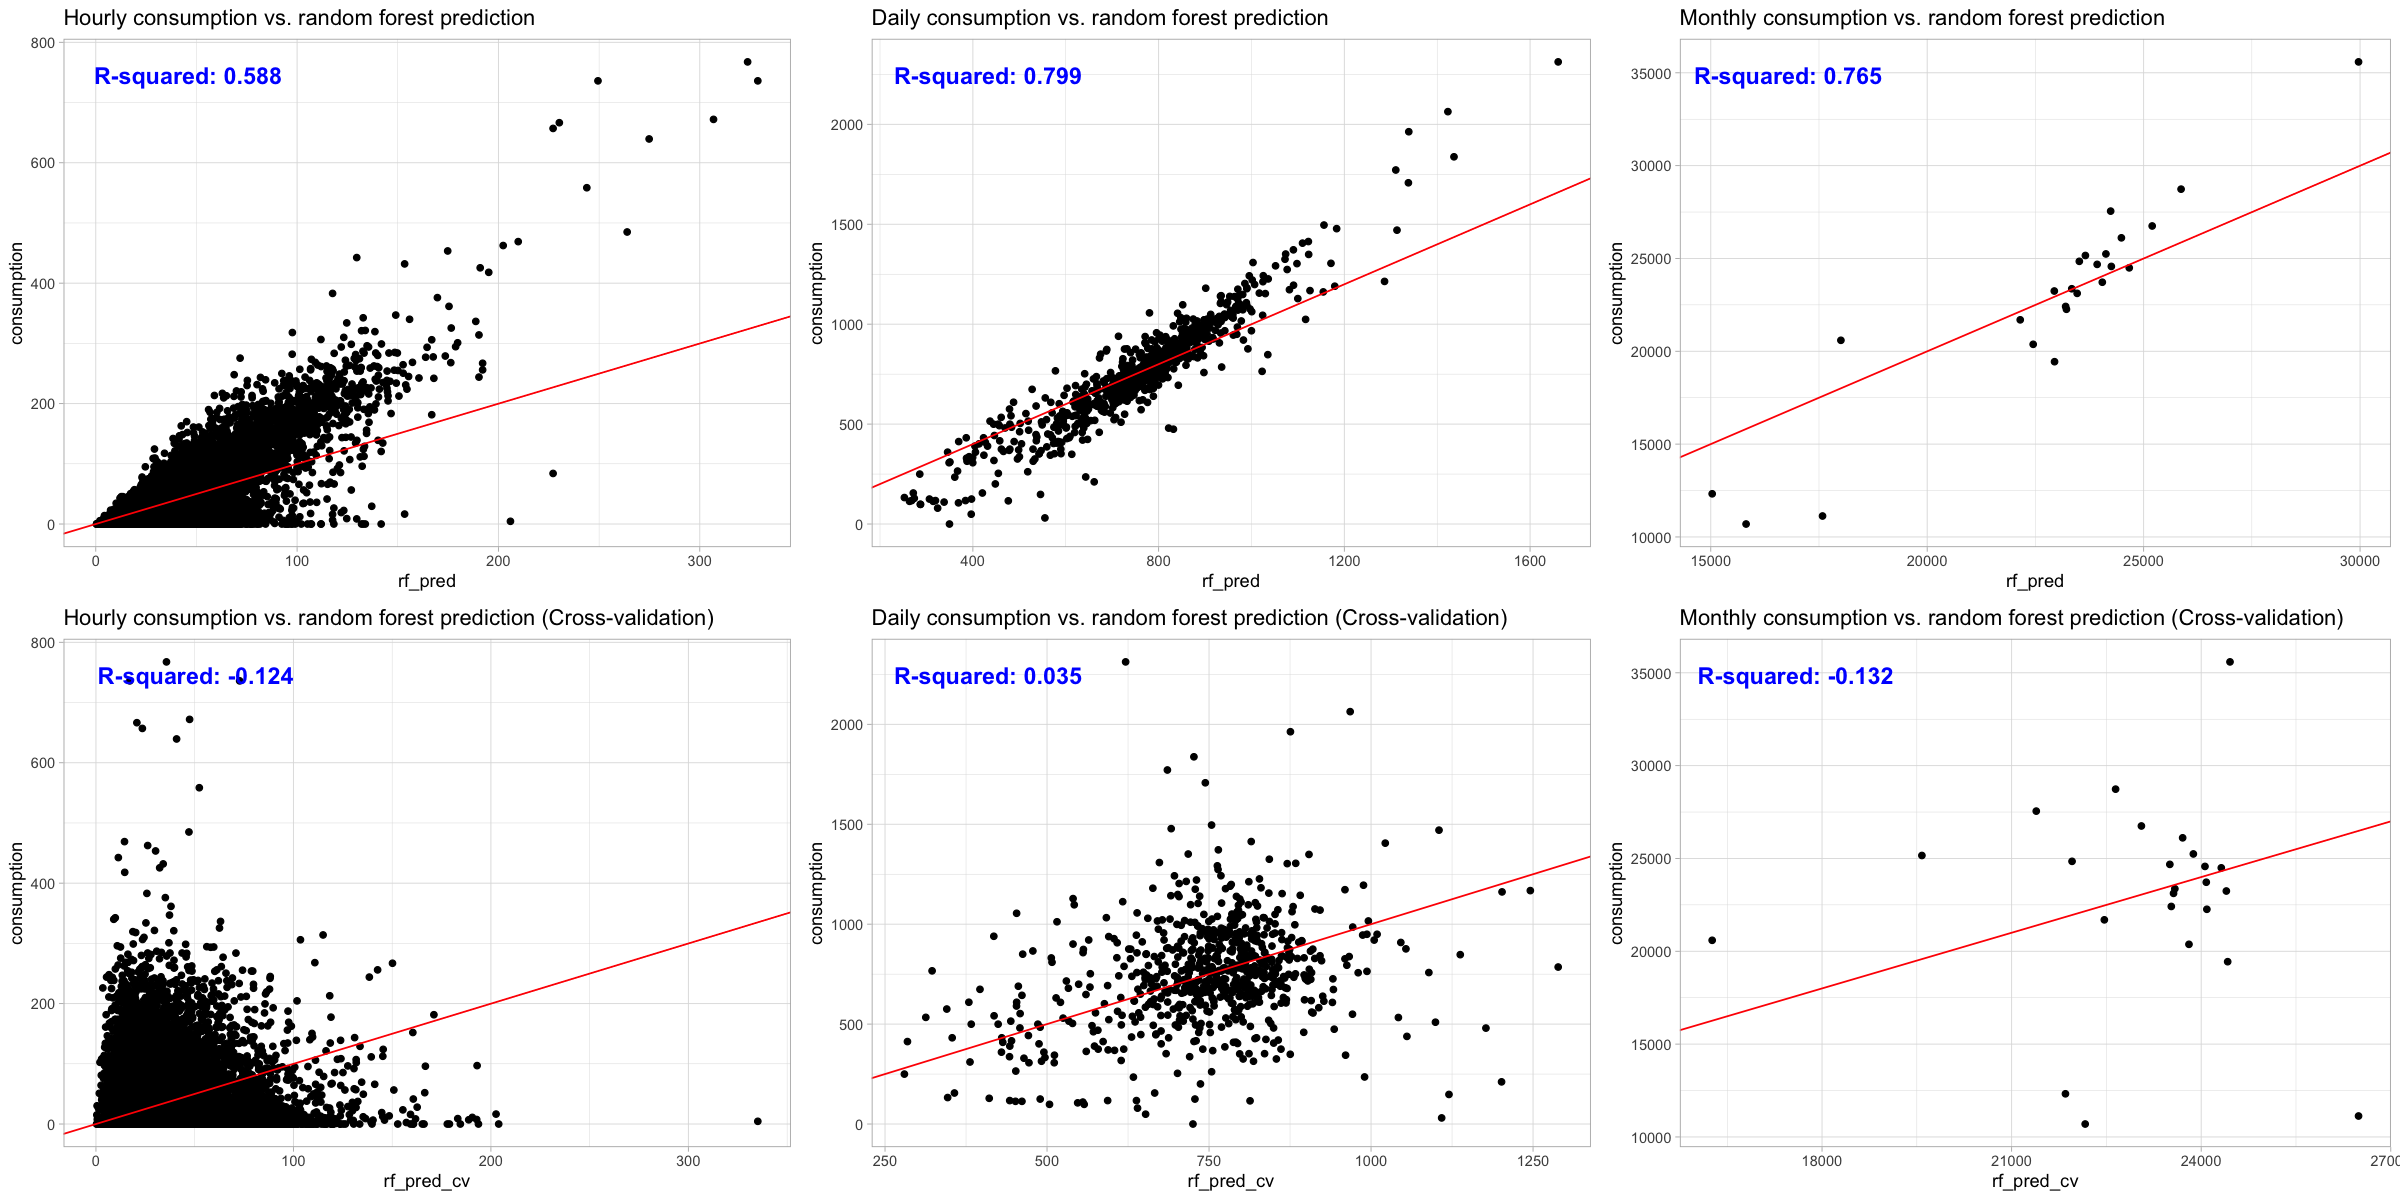

In [16]:
# Set configuration for plot size
options(repr.plot.width = 20, repr.plot.height = 10)

# Plot definitions
plt_hour_rf_pred        <- ggplot(WWHourDF,     aes(x = rf_pred,    y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Hourly consumption vs. random forest prediction")                      + theme_light()
plt_day_rf_pred         <- ggplot(WWDayDF,      aes(x = rf_pred,    y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Daily consumption vs. random forest prediction")                       + theme_light()
plt_month_rf_pred       <- ggplot(WWMonthDF,    aes(x = rf_pred,    y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Monthly consumption vs. random forest prediction")                     + theme_light()
plt_hour_rf_pred_cv     <- ggplot(WWHourDF,     aes(x = rf_pred_cv, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Hourly consumption vs. random forest prediction (Cross-validation)")   + theme_light()
plt_day_rf_pred_cv      <- ggplot(WWDayDF,      aes(x = rf_pred_cv, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Daily consumption vs. random forest prediction (Cross-validation)")    + theme_light()
plt_month_rf_pred_cv    <- ggplot(WWMonthDF,    aes(x = rf_pred_cv, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Monthly consumption vs. random forest prediction (Cross-validation)")  + theme_light()

# Grid of plots definition
plot_grid(
    plt_hour_rf_pred, plt_day_rf_pred, plt_month_rf_pred, plt_hour_rf_pred_cv, plt_day_rf_pred_cv, plt_month_rf_pred_cv,
    labels = c(
        paste0("R-squared: ", round(r_squared_func(WWHourDF,    "consumption", "rf_pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WWDayDF,     "consumption", "rf_pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WWMonthDF,   "consumption", "rf_pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WWHourDF,    "consumption", "rf_pred_cv"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WWDayDF,     "consumption", "rf_pred_cv"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WWMonthDF,   "consumption", "rf_pred_cv"), 3))
    ), 
    hjust = -0.5, vjust = 5, label_colour = "blue",
    ncol = 3, nrow = 2
)

### 8. Models comparison: Linear regression vs. random forest

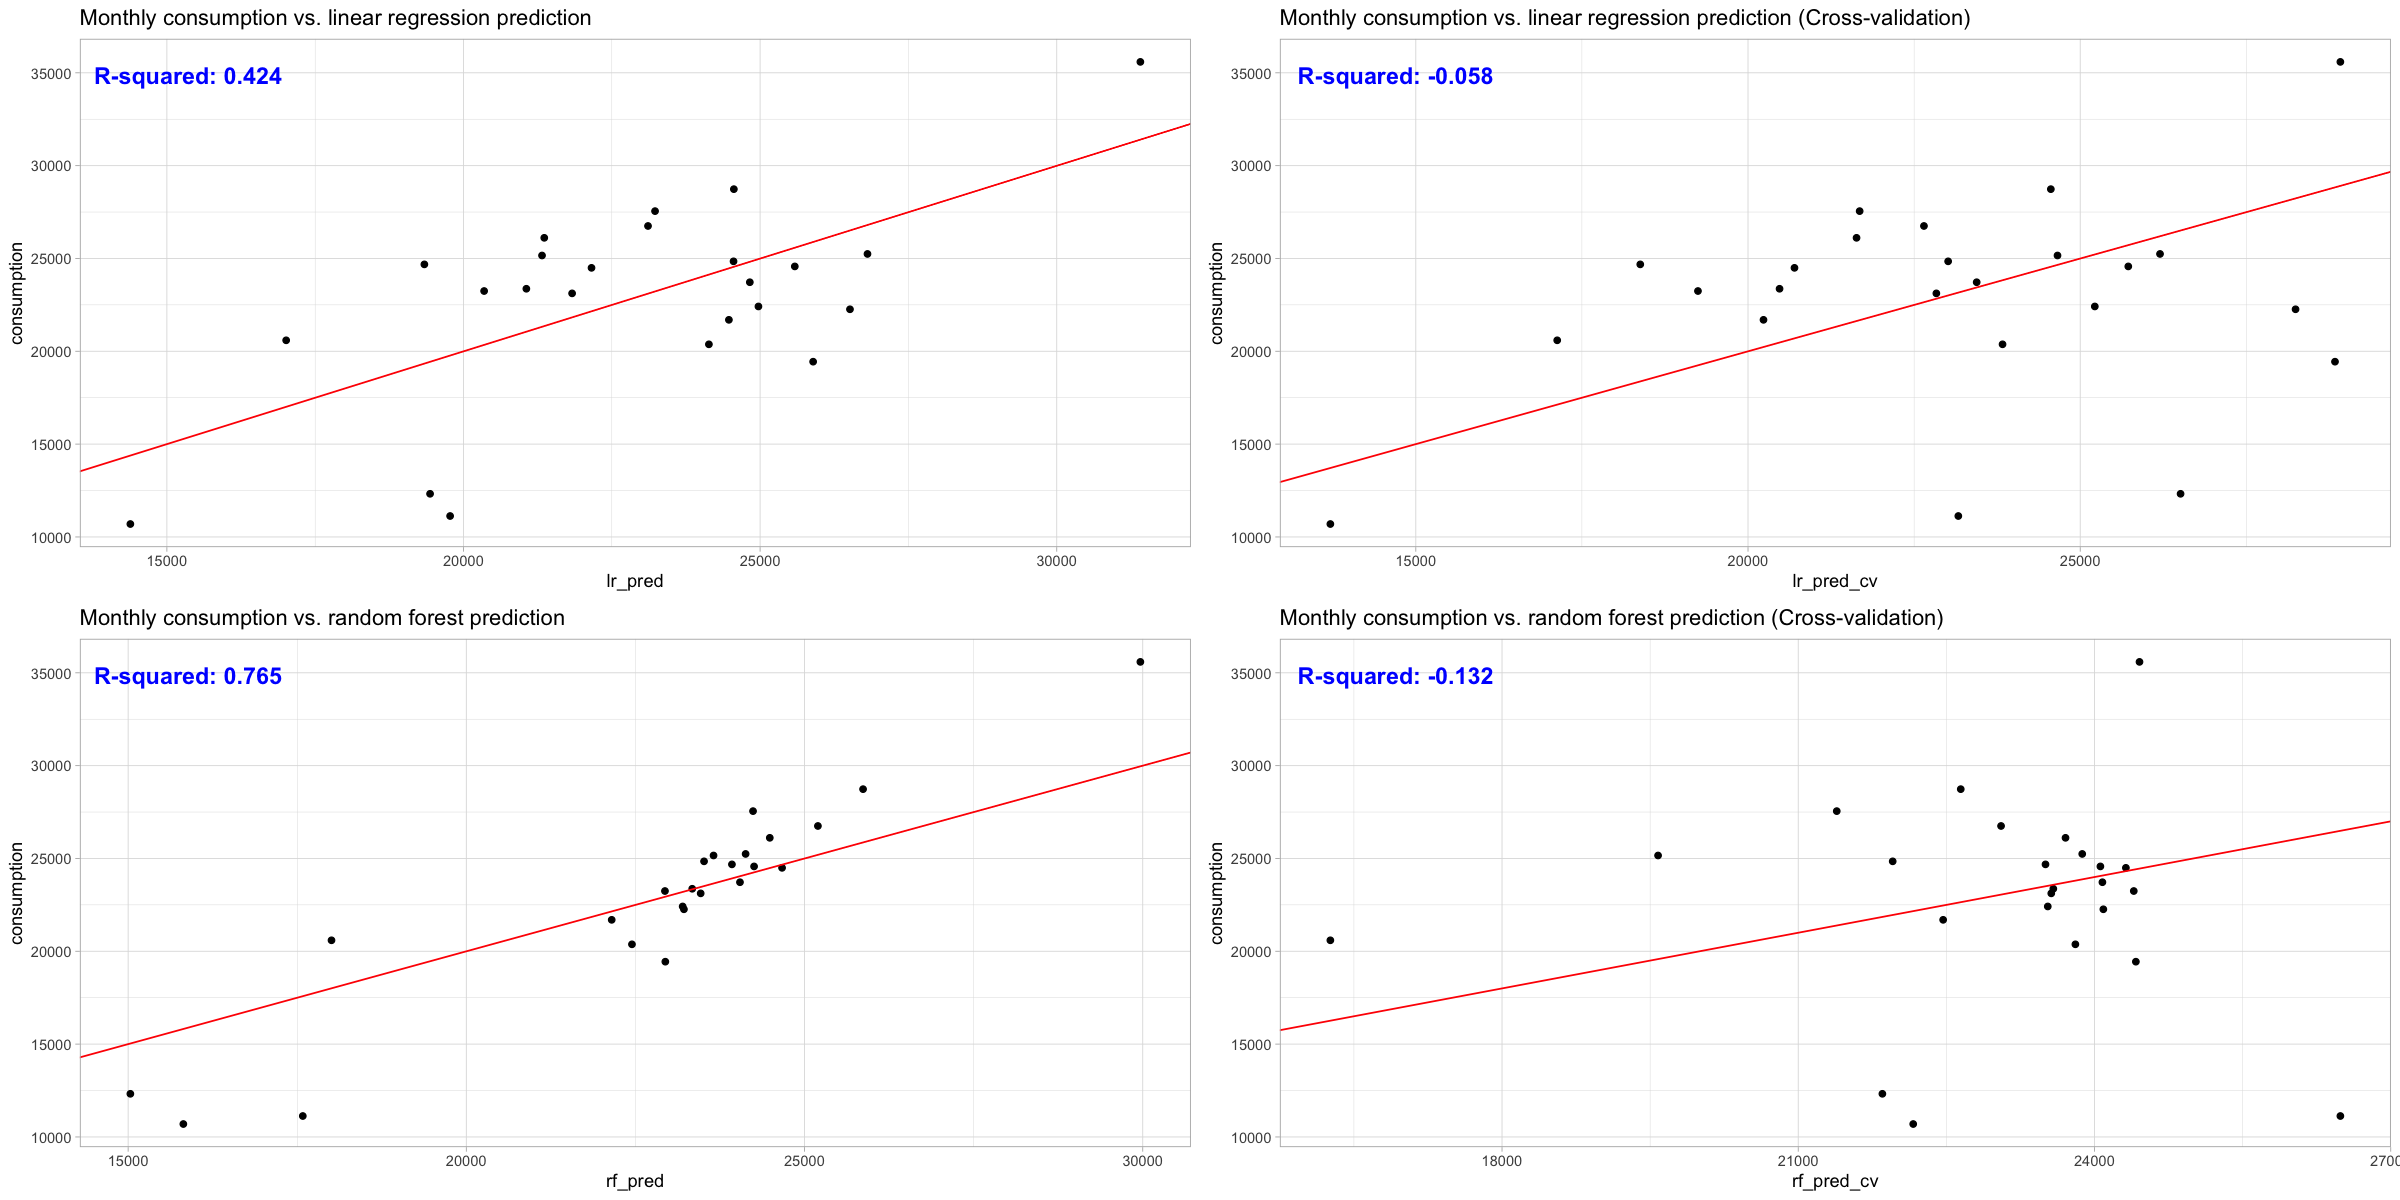

In [17]:
# Set configuration for plot size
options(repr.plot.width = 20, repr.plot.height = 10)

# Plot definitions
plt_month_lr_pred       <- ggplot(WWMonthDF,    aes(x = lr_pred,    y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Monthly consumption vs. linear regression prediction")                     + theme_light()
plt_month_lr_pred_cv    <- ggplot(WWMonthDF,    aes(x = lr_pred_cv, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Monthly consumption vs. linear regression prediction (Cross-validation)")  + theme_light()
plt_month_rf_pred       <- ggplot(WWMonthDF,    aes(x = rf_pred,    y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Monthly consumption vs. random forest prediction")                     + theme_light()
plt_month_rf_pred_cv    <- ggplot(WWMonthDF,    aes(x = rf_pred_cv, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Monthly consumption vs. random forest prediction (Cross-validation)")  + theme_light()

# Grid of plots definition
plot_grid(
    plt_month_lr_pred, plt_month_lr_pred_cv, plt_month_rf_pred, plt_month_rf_pred_cv,
    labels = c(
        paste0("R-squared: ", round(r_squared_func(WWMonthDF,   "consumption", "lr_pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WWMonthDF,   "consumption", "lr_pred_cv"), 3)),
        paste0("R-squared: ", round(r_squared_func(WWMonthDF,   "consumption", "rf_pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WWMonthDF,   "consumption", "rf_pred_cv"), 3))
    ), 
    hjust = -0.5, vjust = 5, label_colour = "blue",
    ncol = 2, nrow = 2
)